In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

from tensorflow.keras.datasets import mnist


# Constants and datasets

In [ ]:
z_dim = 100 #dimensione di z, è un vettore di rumore gaussiano in questo caso

# Gans are very sensitive to hyperparameters, choosing right parameters for
# the optimizer can make the difference between learning and not learning.
optimizer = tf.keras.optimizers.Adam(0.0005,0.6) #cambiando anche di poco questi parametri le cose non funzionano
#bene. Qui istanziamo l'ottimizzatore ove il primo parametro è il learning rate e il secondo è il momento.
#Adam si muove lungo il gradiente e nel muoversi verso una direzione e se la direzione cambia non la segue
#del tutto perchè tiene in considerazione anche la direzione del passo precedente in modo da evitare i
#minimi locali.

batch_size = 128 #usiamo dei minibatch per fare l'addestramento

Few notable things:

- we only need the X_train data
- the labels are scaled to stay between -1 and 1 (using an hyperbolic tangent with the output layer seems to give better results)

In [ ]:
(X_train, _), (_, _) = mnist.load_data() #non ci servono le etichette del dataset quindi non le considero
X_train = X_train / 127.5 - 1. #al posto di dividere per 255 dividiamo per 127.5 - 1 e quindi in questo caso i valori
#andranno da -1 a 1 perchè le X_train vanno da 0 a 255 e quindi quelli che hanno valore 255 alla fine avranno valore 1 mentre i pixel che hanno valore
#0 avranno valore -1. Facciamo questo perchè vogliamo utilizzare la tangente iperbolica perchè in genere
#fornisce immagini meno sfocate.
X_train = X_train.reshape(-1,28,28,1)

# Generator definition

In [ ]:
G_in = Input(shape=[z_dim]) #G sarà il generatore della rete, che avrà in ingresso all'inizio un vettore di pixel con valori casuali
x = G_in
#x = Dense(400, activation="tanh")(x)
x = Dense(784, activation="tanh")(x) #in questo esercizio non usiamo una GAN convolutiva perchè è troppo complicato..


G_out = Reshape([28,28,1])(x)
G = Model(G_in, G_out, name="G")

# Discriminator definition

In [ ]:
D_in = Input(shape=[28,28,1]) #D sarà il discriminatore
x = Flatten()(D_in)
x = Dense(256, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(128, activation="sigmoid")(x)
x = Dropout(0.25)(x)

D_out = Dense(1, activation="sigmoid")(x)

D = Model(D_in, D_out, name="D")

# Let's keep under control few important metrics (tp and tn in particular)
D.compile(loss="binary_crossentropy", optimizer=optimizer,
    metrics=["accuracy",tf.keras.metrics.TruePositives(),tf.keras.metrics.TrueNegatives()]) #utilizziamo la cross entropy binaria
    #come funzione di loss (come detto nella teoria). Chiediamo in output di darci un pò di misure di accuratezza
    #che ci interessa avere sott'occhio come il numero di veri positivi e il numero di veri negativi, questo
    #ci permette di capire se il discriminatore sta rispondendo a caso.

# GAN definition

In [ ]:
gan_in = Input(shape=[z_dim]) #l'input della gan è il vettore z che genereremo a caso
gan_out = D(G(gan_in)) #La Gan in output sostanzialmente mi restituisce la predizione del Discriminatore dopo che ha ricevuto in input
#l'output del Generatore.

gan.layers[2].summary()
gan.compile(loss="binary_crossentropy", optimizer=optimizer) #per ottenere −1/2 * Ez [ log D(G(z)) ] mi basta invertire le etichette prima di darle in input al generatore (l'ha fatto vedere con un esempio durante la lezione)
#questa funzione di loss scritto nella riga sopra la stiamo mettendo su tutta la Gan ma sostanzialmente corrisponde alla loss
#del generatore perchè quando addestreremo il generatore terremo bloccati i pesi del discriminatore.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129   

# Few utility functions

In [ ]:
def generate_random_z(gan, num):
    G = gan.layers[1]
    z_dim = G.layers[0].input.shape[1]

    return np.random.normal(0,1,size=[num, z_dim])

def get_real_imgs(ds, num): #num = numero di immagini che vogliamo recuperare dal dataset che indico con
#con ds(estratti a caso)

    indices = np.random.randint(0, len(ds), size=num)
    return ds[indices]

def get_gen_imgs(gan, num): #in input gli passo il numero di immagini che voglio che il generatore generi
    zs = generate_random_z(gan, num)
    G = gan.layers[1]

    return G.predict(zs)



def show_img_samples(gan, step_no):
    D = gan.layers[2]
    imgs = get_gen_imgs(gan, 25)
    pred_fake = D.predict(imgs) < 0.5

    fig, axes = plt.subplots(5, 5, figsize=(20,20))
    cmaps = { True: "hot", False: "gray" } #dico che voglio dei colori più vivi quando il Discriminatore si
    #accorge che le immagini sono false altrimenti le vedo in grigio, in modo da capire su quali immagini il discriminatore ha sbagliato.

    for i in range(5):
        for j in range(5):
            imgno = i*5 + j
            ax = axes[i,j]


            ax.imshow(imgs[imgno].reshape([28,28]), cmap=cmaps[pred_fake[imgno][0]])




    plt.savefig("/content/sample_data/immagini_generate_dalla_GAN/img_{}.png".format(step_no))

# Main train loop

In [ ]:
def D_train(ds, gan, batch_size): #qui abbiamo uan funzione per fare un passo di training della parte discrinativa
    D = gan.layers[2]
    D.trainable = True

    for i in range(5): #diamo un pò di vantaggio all'addestramento del discriminatore

      x_real = get_real_imgs(ds, batch_size)
      x_gen = get_gen_imgs(gan, batch_size)

      y_real = np.ones(batch_size)
      y_gen = np.zeros([batch_size])

      x = np.concatenate([x_real, x_gen])
      y = np.concatenate([y_real, y_gen])

      perfs = D.train_on_batch(x,y)

    return perfs



def G_train(ds, gan, batch_size): #qui abbiamo uan funzione per fare un passo di training della parte generativa
    D = gan.layers[2]
    D.trainable = False #non aggiorno i pesi del discriminatore

    zs = generate_random_z(gan, batch_size*2) #creo i vettori che conterranno solamente rumore
    y = np.ones([batch_size*2]) #qui praticamente sto invertendo le etichette perchè sto dicendo che le etichette delle immagini generate sono 1 invece di 0.

    return gan.train_on_batch(zs, y) #addestro il generatore dandogli in input tutti i vettori rumorosi che ho creato





def train(gan, ds, steps): #qui abbiamo uan funzione per fare un passo completo sia di generatore che discriminatore
    D = gan.layers[2] #innanzitutto recuperiamo il discriminatore

    for i in range(steps):
        d_loss, d_acc, d_tp, d_tn = D_train(ds, gan, batch_size) #faccio un passo di addestramento del discriminatore

        g_loss = G_train(ds, gan, batch_size) #faccio un passo di addestramento del generatore

        if i % 10 == 0:
            print("\ri:{} G[l:{:0.3f}] D[l:{:0.3f} a:{:0.3f} +:{:0.3f} -:{:0.3f}]"
                .format(i,    g_loss,      d_loss,    d_acc,     d_tp,     d_tn), end="")

        if i % 100 == 0:
            show_img_samples(gan, i)

    show_img_samples(gan, steps)

i:30 G[l:2.044] D[l:0.177 a:0.961 +:123.000 -:123.000]

KeyboardInterrupt: ignored

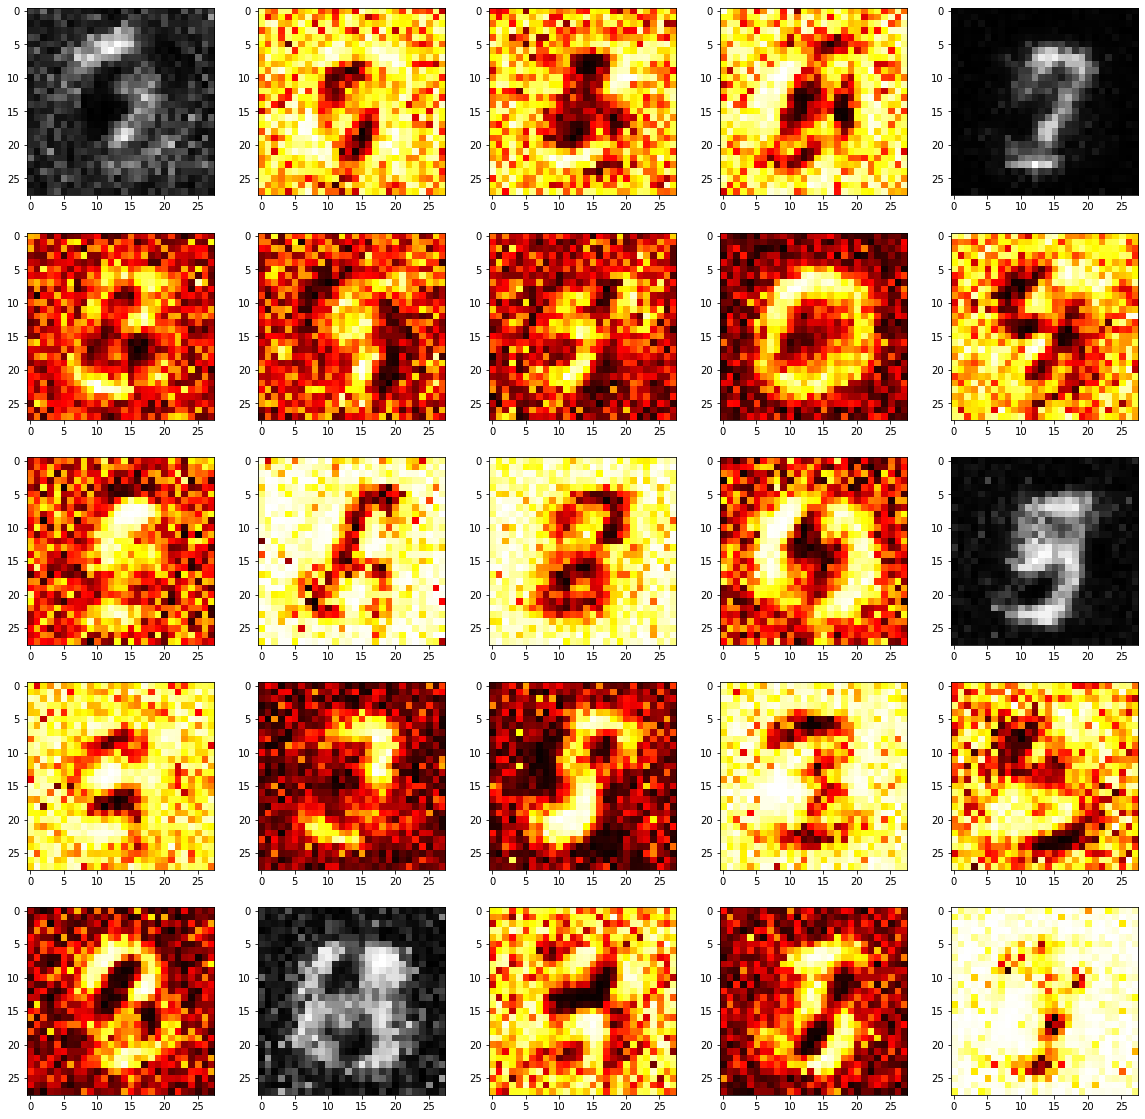

In [ ]:

train(gan, X_train, 10000) #utilizzeremo 10000 passi di addestramento
